# Extracting and processing STM Image Data from Omicron's propritary .Z_MTRX format 
In order to extract the images, first import the necessary packages. We will be using NanoscoPy to read the STM data and matplotlib to show the data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
# Custom modules
import sys
sys.path.append('../../NanoscoPy/')
from nanoscopy import spm
from nanoscopy.utilities import dialog_askdirectory

### Get Root Folder Path
Prompt the user for the directory which contains the .Z_mtrx files and the result file chain.

In [31]:
folder_path = dialog_askdirectory()

### Read all STM files in the folder

In [32]:
scans = spm.read(folder_path, metadata_source='filepath')

 Reading 3 mtrx images...Done ########## [100.00%]


### Check metadata summary

In [16]:
scans[0].summary()

'SL458-9_1to100_220114_-2.0V_25x25_6_1_Z'

### Collect forward trace images

In [33]:
fwd_scans = [spm_data.fwd() for spm_data in scans]

### Correct the forward sweep data
Each image is globally flattened via plane correction, followed by 2nd order polynomial background subtraction, line-by-line offset flattening, 3x3 gaussian smoothing, and CLAHE.

In [35]:
corrected_scans = spm.correct(fwd_scans, poly=True, equalize=True)

 Corrcting images...Done ########## [100.00%]


### Show a comparison plot between some of the raw and processed images

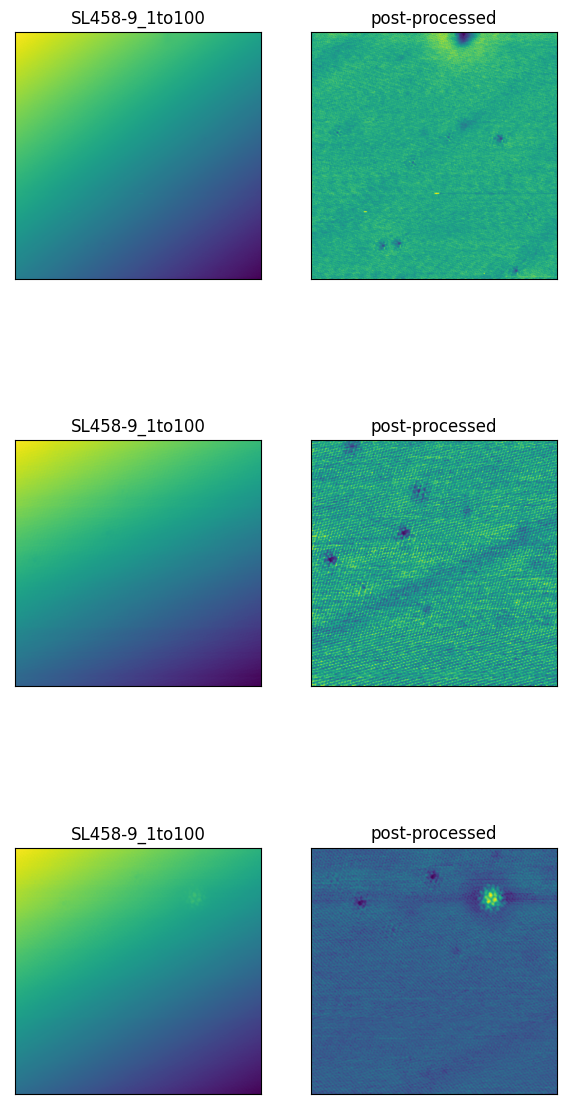

In [36]:
n = len(corrected_scans[:5])
fig, axs = plt.subplots(n, 2)
fig.set_figheight(15)
fig.set_figwidth(7)

for i in range(n):
    raw = scans[i]
    processed = corrected_scans[i]
    sample_name = f'{raw.sample_id()}'
    # sample_name = 'Original'

    axs[i, 0].imshow(raw.fwd() , origin = 'lower')
    axs[i, 0].set_title(sample_name)
    axs[i, 1].imshow(processed , origin = 'lower')
    axs[i, 1].set_title(f'post-processed')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

### Output directories 

In [37]:
dst_paths = [f'{Path(scan.path()).parent}\\{scan.summary()}.jpg' for scan in scans]
dst_paths

['C:\\Users\\da935101\\Datasets\\TMDs\\WSe2\\Hone-Barmak\\SL458-9_1to100\\220426\\SL458-9_1to100_220426_-1.7000000000000002V_37x37_11_18_Z.jpg',
 'C:\\Users\\da935101\\Datasets\\TMDs\\WSe2\\Hone-Barmak\\SL458-9_1to100\\220426\\SL458-9_1to100_220426_-1.7000000000000002V_25x25_5_4_Z.jpg',
 'C:\\Users\\da935101\\Datasets\\TMDs\\WSe2\\Hone-Barmak\\SL458-9_1to100\\220426\\SL458-9_1to100_220426_-1.7000000000000002V_25x25_5_7_Z.jpg']

### Export the data as jpg

In [38]:
spm.io.export_images(corrected_scans, dst_paths)

### Export metadata as csv 

In [39]:
spm.io.export_metadata(scans, folder_path)